# WineMag Review

## Load the Data

import pandas for reading and data manipulation 

In [1]:
import pandas as pd

Download the dataset and read it with pandas.

**winemag-data-130k-v2.csv** contains 10 columns and 130k rows of wine reviews.

In [7]:
dataset_path = "~/Fall2023/ENSF619/winemag-data-130k-v2.csv" 
data = pd.read_csv(dataset_path, comment='#')

In [8]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87.0,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87.0,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87.0,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87.0,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87.0,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


As we can see some values of the table are missing.

## Visualization

Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [9]:
data.describe()

,Unnamed: 0,points,price
count,129971.000000,129865.000000,120870.000000
mean,64985.000000,88.446933,35.360908
std,37519.540256,3.039657,41.032140
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


### Bar Chart

<Axes: >

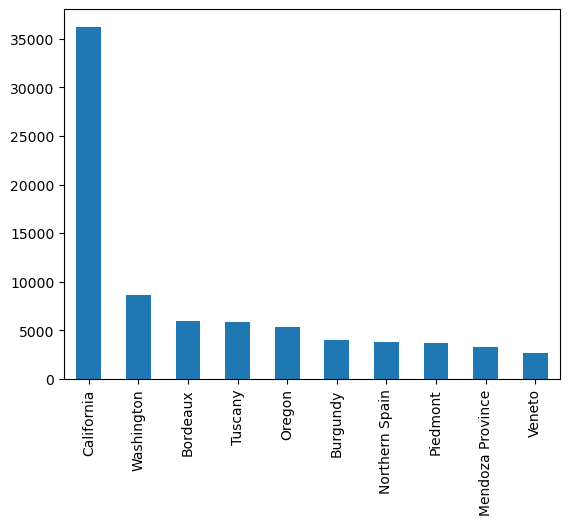

In [10]:
data['province'].value_counts().head(10).plot.bar()

This means california make the most of wine in the world. 

<Axes: >

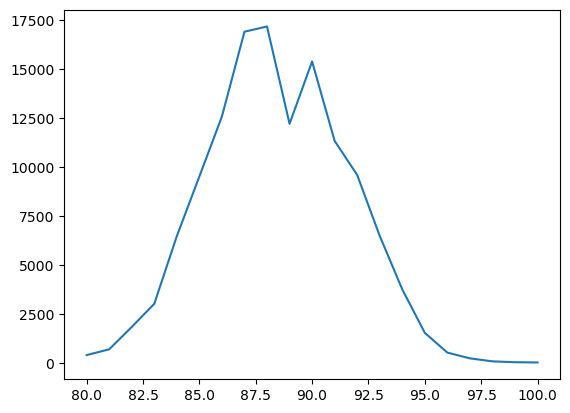

In [11]:
data['points'].value_counts().sort_index().plot.line()


<Axes: xlabel='price', ylabel='points'>

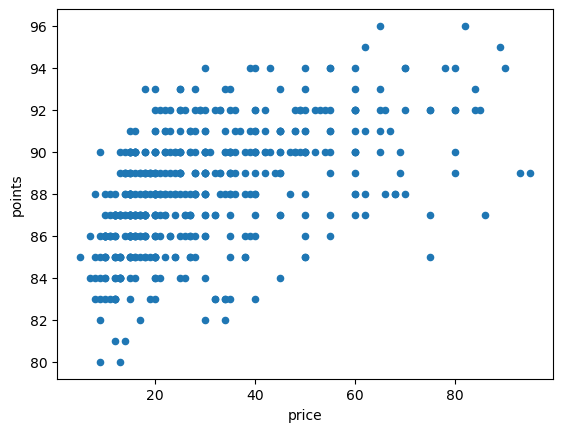

In [12]:
data[data['price'] < 100].sample(500).plot.scatter(x='price', y='points')


## Data Preprocessing

We see that there is a column called 'Unnamed: 0', which contains IDs of each wine. IDs are of course can't help us in order to regression, so we should drop this column. We will also drop description column.

In [13]:
data=data.drop(columns=['Unnamed: 0', 'description'])
data=data.reset_index(drop=True)

First, let's find out the number of missing values in each coloumn.

In [14]:
data.isnull().sum()

country                     63
designation              37469
points                     106
price                     9101
province                   169
region_1                 21325
region_2                 79518
taster_name              26325
taster_twitter_handle    31287
title                      106
variety                    107
winery                     106
dtype: int64

Some of them are hard to calcualte so we could fill some coloumns with specific value.

In [15]:
data["region_1"] = data.region_1.fillna("Unknown")
data["region_2"] = data.region_2.fillna("Unknown")

In [16]:
data.isnull().sum()

country                     63
designation              37469
points                     106
price                     9101
province                   169
region_1                     0
region_2                     0
taster_name              26325
taster_twitter_handle    31287
title                      106
variety                    107
winery                     106
dtype: int64

So now region_1 and region_2 column has no nan value.

### Missing Values 

We don't want to predict points for wines which price are undeclared. We will drop rows with NaN value in this column.

In [17]:
data = data.dropna(subset=['price'])
data = data.reset_index(drop=True)

We will prepare our train and test data. We will use sklearn Library.

In [18]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, cv

X = data.drop(columns=['points'])

X = X.fillna(-1)
print(X.columns)

Index(['country', 'designation', 'price', 'province', 'region_1', 'region_2',
       'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')


In [19]:
categorical_features_indices = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]

y = data['points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)

## Model Training

Create CatBoostRegressor model with Mean squared error loss function.



In [20]:
def train_model(X_train, y_train, X_valid, y_valid, X_test, y_test):
    model = CatBoostRegressor(
        random_seed = 400,
        loss_function = 'RMSE',
        iterations=200,
    )
    
    model.fit(
        X_train, y_train,
        cat_features = categorical_features_indices,
        eval_set=(X_valid, y_valid),
        verbose=False
    )
    
    print("RMSE on training data: "+ model.score(X_train, y_train).astype(str))
    print("RMSE on test data: "+ model.score(X_test, y_test).astype(str))
    
    return model

In [21]:
model = train_model(X_train, y_train, X_valid, y_valid, X_test, y_test)


RMSE on training data: 0.751966340377935
RMSE on test data: 0.5672667676037036


Now we can plot the feature based on their effect on result.

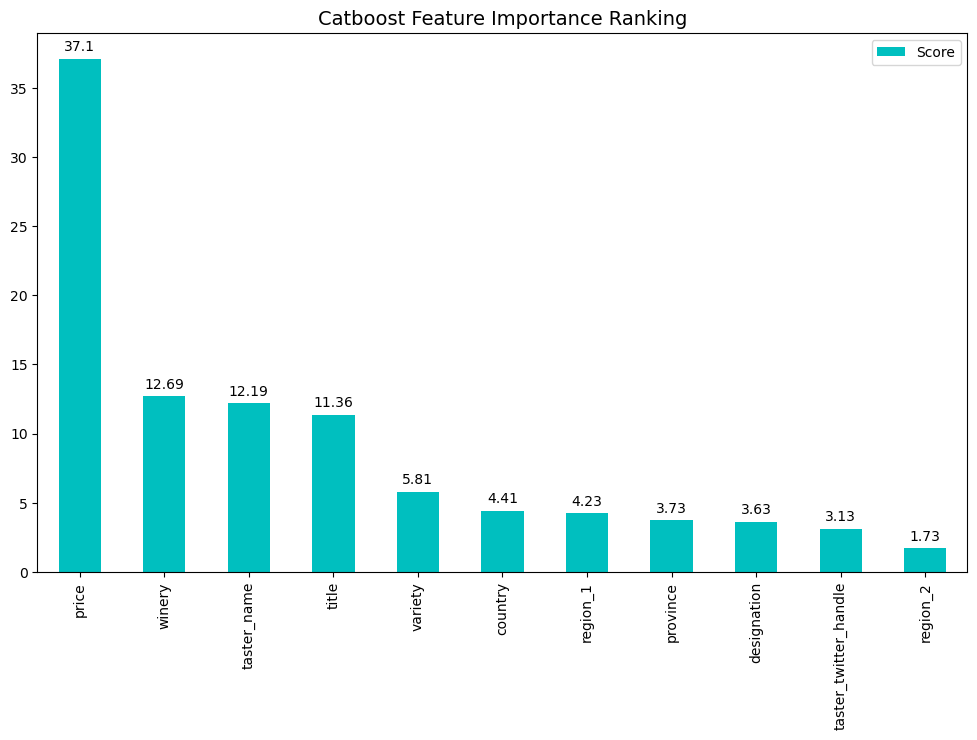

In [23]:
import matplotlib.pyplot as plt

feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

Drop 3 columns which gives least information.

In [25]:
X = data.drop(columns=['points','title', 'region_1'])
X = X.fillna(-1)
categorical_features_indices =[0,1,3,4,5,6,7,8]
y = data['points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)

In [26]:
model = train_model(X_train, y_train,X_valid, y_valid,X_test, y_test)


RMSE on training data: 0.6596654042082657
RMSE on test data: 0.5502977517152658
